# Attention is all you need 논문 리뷰


## 요약

기존의 sequence transduction 모델들은 인코더, 디코더를 포함한 복잡한 RNN이나 CNN 알고리즘을 사용했었다. 하지만 논문에서 제안하는 Transformer 모델은 RNN, CNN 알고리즘을 제거하고 attention 메커니즘만을 사용한다. Transformer는 병렬적으로 학습을 진행하기에 기존의 모델들에 비해 높은 성능과 단축된 학습시간을 보여준다. Transformer 모델은 매우 유명한 두가지 번역 과제(WMT 2014 영어-독일어, 영어-불어 번역 과제)에서 짧은 학습시간 안에 우수한 성능을 보여주며 모델의 효력을 증명하였다.

## 1. 서론

RNN을 비롯한 LSTM, GRU 등의 신경망 모델은 기계번역이나 언어 모델링과 같은 시퀀스 변형 및 시퀀스 모델링 문제에 state-of-art 수준의 해결책으로 자리매김해왔다. 하지만 순환 신경망(RNN)은 $h_{t}$를 도출하기 위해 이전 $h_{t-1}$을 입력으로 받기에 병렬처리가 불가능하다. 이는 시퀀스 길이가 길어지면서 메모리 및 속도 측면에서 치명적인 결함을 갖는다. 최근 연구는 factorization tricks와 conditional computation으로 효율성과 성능을 높였지만 시퀀스 연산에 근본적인 제약은 여전히 남아있다.  

Attention mechanism은 input과 output의 시퀀스 길이와 무관하게 dependency를 모델링할 수 있어 중요한 요소로 생각되었으나 대부분 순환신경망과 결합하여 사용되었다.  

본 논문에서는 recurrence를 배제하고 attention mechanism만을 전적으로 사용함으로써 입력과 출력 사이 global dependency를 찾는 Transformer 모델을 제안한다. Transformer 모델은 병렬구조를 획기적으로 늘리며 state-of-art 수준의 번역 성능을 짧은 시간 내에 달성할 수 있다.

## 2. 배경

Sequential 연산을 줄이기 위해 Extended Neural GPU, ByteNet, ConvS2S 등 다양한 모델이 제안되었다. 이 모델들은 CNN에 기반하여 모든 입력과 출력의 위치에 병렬적으로 hidden state을 계산한다. 이러한 계산은 입력과 출력의 거리가 길어질수록 연산량이 선형 혹은 대수적으로 증가한다는 단점이 있다. 거리가 먼 경우, 입력과 출력의 dependency를 학습하기 어렵기 때문이다. 이와 달리, Transformer 모델의 경우, 연산량이 일정한 수로 줄어든다. attention-weighted position을 평균화함에 따라 효율이 감소한다는 문제가 있지만 이는 Multi-Head Attention을 사용함으로써 해결할 수 있다.  

Self-attention은 주어진 문장 내에서 토큰끼리 서로 다른 위치에 대한 가중치를 부여하며 attention을 수행하는 원리로 이루어져있다. Self-attention 메커니즘은 독해, 요약 등 다양한 분야에서 좋은 성능을 보여준다.  

End-to-end memory network는 sequence aligned recurrence 대신 recurrent attention mechanism을 기반으로 simple-language question answering과 language modeling task에서 좋은 성능을 내었다.

Transformer는 sequence-aligned RNN이나 CNN을 사용하지 않고 self-attention에만 온전히 집중하여 입력과 출력의 representation을 연산하는 알고리즘이다. 이어서 본 논문은 Transformer 구조와 타 모델에 비해 transformer가 가지는 장점에 대해 소개한다.

## 3. 모델 구조
대부분의 sequence transduction 모델들은 인코더-디코더 구조를 갖는다. 인코더에서는 $(x_{1},...,x_{n})$ 입력 시퀀스를 $z=(z_{1},...,z_{n})$로 변환해준다. 이후 디코더에서 $z$를 기반으로 $(y_{1},...,y_{m})$ 시퀀스를 출력한다. 이 과정에서 RNN을 따르는 모델들은 auto-regressive하게 이전에 생성된 symbol을 추가적으로 입력 받아 그 다음을 출력한다. 반면, transformer 모델은 recurrent network 대신 attention을 활용해 시퀀스에 대한 입력을 병렬적으로 받는다는 점에서 차이가 있다. 

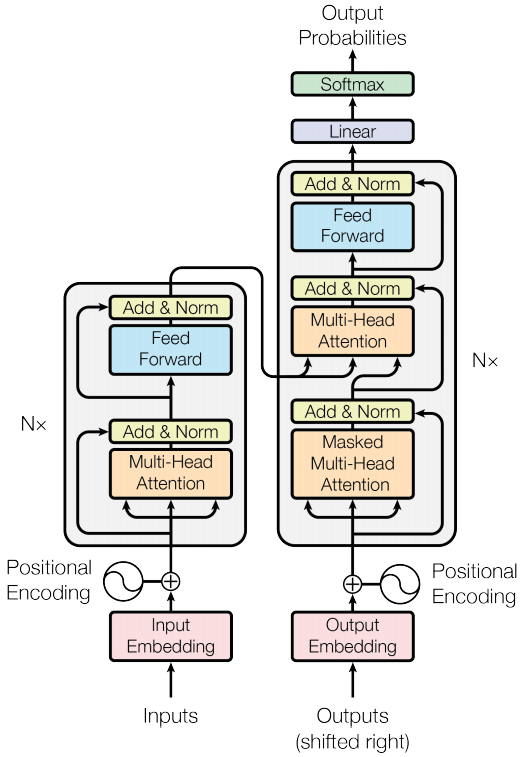
### 3-1) Encoder & Decoder Stacks

- Enconder: 그림과 같이 인코더는 본 논문에서 6개의 동일한 layer로 쌓이게 된다. 각 layer는 두개의 sub-layer로 이루어져 있으며, 첫 번째는 multi-head self attention mechanism이고 두 번째는 position-wise fully connected feed forward network이다. 또한, residual connection을 사용하기에 sub-layer의 각 출력값은 $LayerNorm(x + Sublayer(x))$이 된다. 임베딩 벡터의 차원은 이러한 모델 구조의 layer를 잘 활용할 수 있는 512로 설정했다.

- Decoder: 디코더 또한 인코더 구조와 같이 6개의 동일한 layer로 구성된다. 이와 더불어 인코더를 거친 출력값에 multi-head attention을 수행하는 세 번째 sub-layer를 가진다. 마찬가지로 각 sub-layer에 residual connection과 layer normalization을 사용한다. decoder의 self-attention sub-layer에서는 현재 위치보다 뒤에 있는 요소에 attention을 적용하지 못하도록 masking을 추가해준다. position $i$에 대한 예측을 위해 $i$ 이전에 있는 정보들만 사용하도록 하는 것이다.

### 3-2) Attention
Attention function은 query와 key-value 쌍을 output에 매핑하는 것으로 설명할 수 있다. 여기서 key, value, query, output은 모두 벡터로 이뤄진다. output은 value 값의 가중치 합으로 계산되며 이러한 가중치는 key와 query의 compatibility function으로 계산된다.


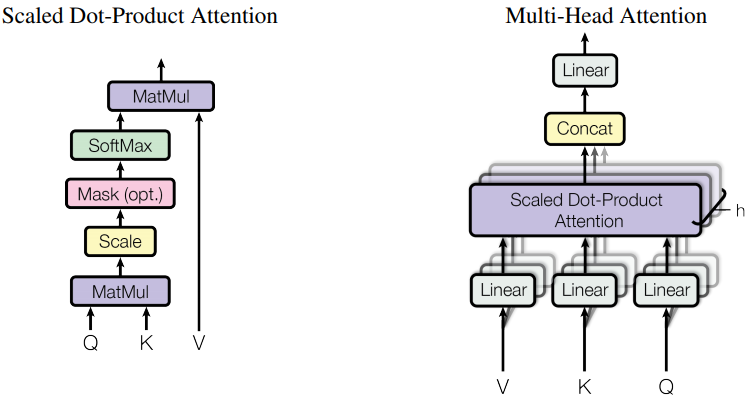



#### **3-2-1) Scaled Dot-Product Attention**  
Scaled Dot-Product Attention의 구조는 위 그림의 왼쪽에 나타나 있다. 입력으로는 
$d_{k}$차원의 query, key와 $d_{v}$차원의 value를 가진다. value에 대한 가중치는 query와 key의 내적에 $\sqrt{d_{k}}$로 나누어 스케일링을 한 후, softmax 연산을 적용해서 얻을 수 있다. 이를 수식으로 표현하면 아래와 같다.  

\begin{align*} \
\text{Attention}(Q,K,V)=\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
\end{align*} \\
가장 자주 쓰이는 attention function은 additive attention과 dot-product(multiplicative) attention이다. 두 함수는 이론적인 복잡도는 비슷하지만 앞서 사용된 dot-product attention이 훨씬 빠르고 공간 효율적이다. 

그러나 dot-product attention에 $\frac{1}{\sqrt{d_{k}}}$ 스케일링 과정이 없을 경우, dot-product attention의 성능은 additive function보다도 떨어진다. 본 논문에서는 그 원인을 softmax fuction의 특성에서 찾는다. 임베딩 벡터의 차원이 커질수록 내적 값이 매우 커지는데 softmax fuction에서 이러한 값은 매우 작은 gradient를 가지기 때문이다. 따라서, 이러한 현상을 막기 위해  $\frac{1}{\sqrt{d_{k}}}$ 스케일링을 적용해주는 것이다.

#### **3-2-2) Multi-Head Attention**  
$d_{model}$ 차원의 key, value, query를 활용하여 하나의 attention 값을 구하는 것보다 query, key, value를 각각 서로 다르게 학습된 $d_{k}$, $d_{k}$, $d_{v}$ 차원으로 $h$번 투영하는 것이 더욱 효과적이다. Multi-head attention은 query, key, value가 각각 투영된 값에 대해 앞서 언급한 scaled dot-production attention을 병렬적으로 계산한다. 이로써 산출된 $d_{v}$차원의 output은 병합되고, 한번 더 투영된 후, 최종 값이 산출된다. 수식은 다음과 같다.  
\begin{align*} \
\text{MultiHead}(Q,K,V)=\text{Concat}(\text{head}_1,...,\text{head}_h)W^O\\ \text{where} \ \text{head}_i=\text{Attention}(QW_i^Q,KW_i^K,VW_i^V)\\
\end{align*} \\
query, key, value 투영 행렬은 각각 다음과 같다. 
\begin{align*} \
W_i^Q\in \Bbb R^{d_{\text{model}}\times d_k}, W_i^K\in \Bbb R^{d_{\text{model}}\times d_k}, W_i^V\in \Bbb R^{d_{\text{model}}\times d_v}
\end{align*} \\
아래는 $d_{v}$차원의 output이 병합된 후 마지막으로 투영되는 행렬이다.
\begin{align*} \
W_i^O\in \Bbb R^{hd_{{v}}\times d_{\text{model}}}
\end{align*} \\

본 논문에서는 8개의 parallel attention layers(heads)를 사용했다.  $d_{\text{model}}=512$, $h=8$이기에 $d_{k} = d_{v} = d_{\text{model}}/h = 64$. 각 head에서 사용하는 차원 수가 64로 줄어들었기에 총 연산량은 single-head attention과 비슷하다.  

#### **3-2-3) Applications of Attention in our Model**  
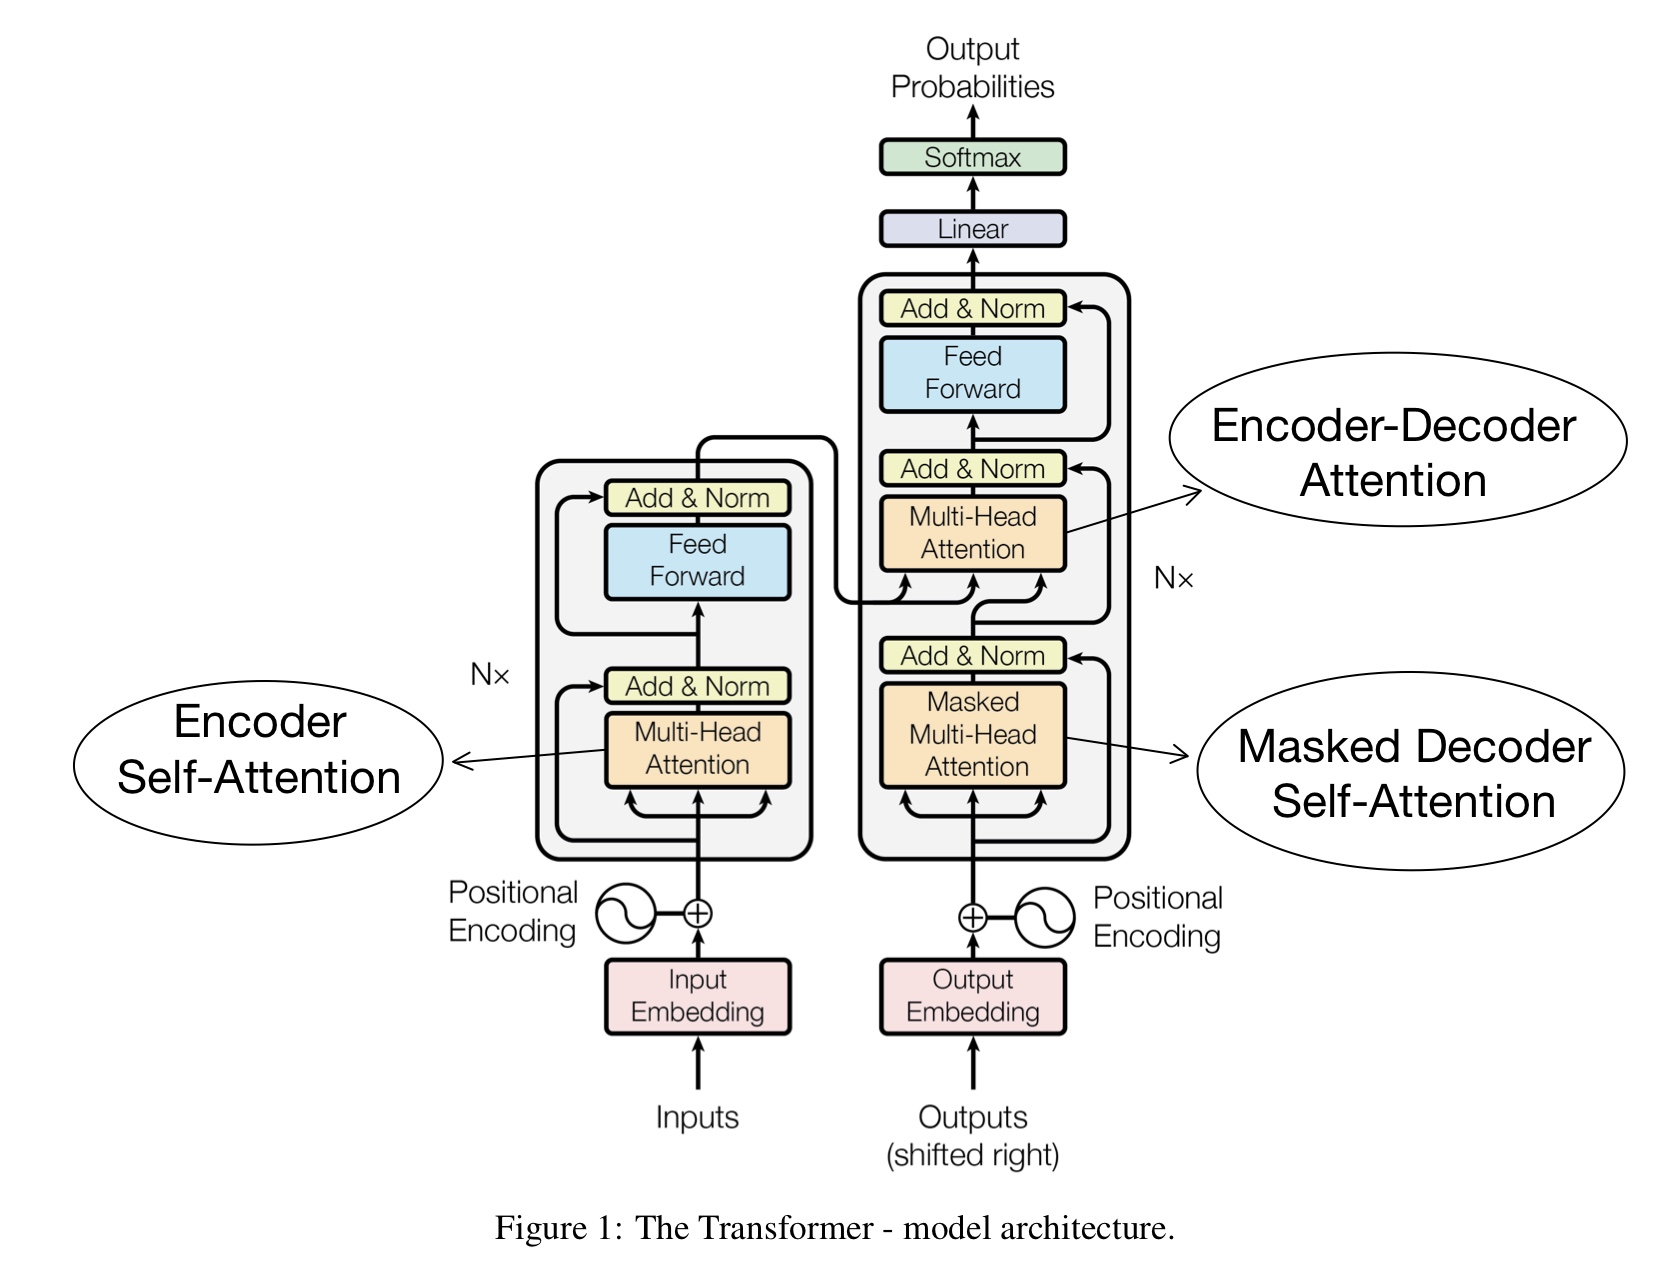

Transformer에서 multi-head attention은 세 군데 위치에서 사용된다.  

1. “Encoder-Decoder Attention” layer에서 query는 이전 decoder layer에서 오고, key, value는 encoder의 output에서 온다. decoder의 모든 position에서 input sequence(encoder output)의 모든 position에 attention을 적용할 수 있도록 한다.  

2. “Encoder Self-Attention”에서 모든 key, value, query는 이전 encoder layer output에서 온다. encoder의 각 position에서는 이전 encoder layer의 모든 position에 대해 attention을 적용할 수 있다.  

3. “Masked Decoder Self-Attention” layer에서는 decoder의 각 position에 대해 해당 position 이전까지만 attention을 적용할 수 있도록 한다. 즉, scaled dot-product attention에 masking out을 적용한 layer라고 볼 수 있다. masking out은 i번째 position에 대한 attention을 계산할 때, i+1번째 이후 모든 position은 softmax 함수에 −∞를 입력함으로써 attention을 얻지 못하도록 하는 것이다.


### 3-3) Position-wise Feed-Forward Networks

attention sub-layer와 더불어 transformer의 인코더와 디코더는 각각 fully connected feed-forward network layer를 포함한다. Feed-forward network는 두 선형 변환식과 ReLU 활성화함수로 구성된다. 선형 변환식은 서로 다른 position에서도 같지만 층마다 다른 파라미터를 사용한다. 입력 벡터의 차원은 512이며 inner-layer에서는 2048 차원으로 늘어나지만 결국 출력 벡터의 차원은 다시 512로 줄어든다. Position-wise Feed-Forward Network을 수식으로 표현하면 다음과 같다.  
\begin{align*} \
\text{FFN}(x)=\text{max}(0,xW_1+b_1)W_2+b_2
\end{align*} \\

### 3-4) Embeddings & Softmax
sequence transduction model과 유사하게 transformer 모델 또한 입력과 출력 token의 차원을 변환하기 위해 학습된 임베딩을 사용한다. 또한, 학습된 선형 변환과 softmax 함수를 이용해 decoder output을 다음 token을 예측하기 위한 확률로 변환한다. 본 모델은 두 embedding layer와 linear transformation 사이에서 동일한 가중치 행렬을 공유한다. Embedding layer의 가중치는 $\sqrt{d_{\text{model}}}$
을 곱해준다.  

### 3-5) Positional Encoding
Transformer 모델은 순환이나 합성곱의 개념을 사용하지 않기 때문에 입력값의 순서를 고려하기 위해서는 sequence 내 token들이 가지는 상대적 혹은 절대적 위치에 관한 정보를 주입시켜야 한다. 따라서 모델의 encoder와 decoder의 밑바닥에 있는 input embeddings에 "positional encoding"을 추가한다. Positional encoding은 임베딩 벡터 $d_{\text{model}}$의 차원인 512와 동일하다. 
본 논문에서는 sine, cosine 함수를 활용해 모델이 상대적 위치에 대해 attention을 보다 잘 학습할 수 있도록 하였다. 사용한 함수는 아래와 같다.  

\begin{align*} \
PE_{(pos,2i)}=sin(pos/10000^{2i/d_{\text{model}}})\\
PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{\text{model}}}) 
\end{align*}

## 4. 왜 Self-Attention인가?
Self-Attention을 사용하여 얻는 이점은 3가지이다.
1. layer의 총 계산 복잡도의 감소
2. 입력 토큰 병렬화를 통한 연산량의 감소
3. 긴 거리의 dependency까지 우수하게 학습 가능

RNN과 비교했을 때, transformer는 입력을 병렬적으로 처리하기 때문에 network에 들어가는 입력의 횟수가 적다. 또한 layer별 복잡도를 보았을 때, 단어의 개수인 $n$이 일반적으로 $d$보다 작게 형성되는 경우가 많다. 따라서 $n^{2}\times d$가 $n\times d^{2}$보다 낮을 확률이 높기에 transformer모델이 유리한 복잡도를 가진다고 볼 수 있다.  
추가적으로 attention mechanism 자체가 신경망 모델을 보다 설명 가능한 모델로 만들어준다는 장점이 있다. 실제로 각 단어를 출력할 때, 소스 문장에서 어떤 단어를 가장 많이 참고했는지 시각적으로 확인할 수 있기 때문이다. 이는 head에 포함된 self-attention mechanism의 softmax를 출력해봄으로써 가능하다.

## 5. 학습  
### 5-1) Training Data and Batching
  4.5M개의 문장 쌍이 있는 WMT 2014 English-German dataset을 사용했다. 36M개의 문장 쌍을 포함하는 WMT 2014 English-French dataset도 사용했다. 각 batch마다 약 25000개의 source token과 target token을 포함하는 문장 쌍을 가지도록 했다.

### 5-2) Optimizer
본 논문에서는 $\beta_1 = 0.9, \ \beta_2=0.98, \ \epsilon=10^{-9}$를 parameter로 갖는 Adam optimizer를 사용했다. 또한 아래와 같은 식에 따라 변화하는 learning rate를 사용했다.
\begin{align*} \
lrate=d_{\text{model}}^{-0.5}\cdot \text{min}(step\text{_}num^{-0.5},step\text{_}num\cdot warmup\text{_}steps^{-1.5})
\end{align*}

이 식에서 learning rate는 첫번째 $warmup\text{_}step$동안 선형적으로 증가하고, 그 이후로는 $step\text{_}num$의 역제곱근에 비례하여 감소한다. 본 논문에서는 
$warmup\text{_}step=4000$을 사용했다.

### 5-3) Regularization
**Residual Dropout**  
sub-layer의 각 output이 input으로 사용되거나 normalized 되기 전에 dropout을 적용했다. 추가로 각 encoder, decoder stack에 embedding과 postional encoding을 더해 dropout을 적용했다. 기본적으로 $P_{drop}=0.1$을 사용했다.  

**Label Smoothing**  
학습이 진행되는 동안 $\epsilon_{ls}=0.1$값을 갖는 label smoothing을 적용했다. 이를 통해 transformer 모델이 특정 출력값에 확신을 가지지 않도록 함으로써 정규화 효과를 더했다. 이는 perplexity를 높이지만 정확도와 BLEU score가 높아진다는 장점이 있다. 

## 6. 결론
본 논문에서는 recurrent layer를 multi-head self-attenton으로 대체한 첫번째 sequence transduction model인 transformer를 제시했다. translation tasks에서 transformer는 다른 어떤 recurrent나 convolution 모델보다도 더 빠르게 학습하고, 더 좋은 성능을 보이며 자연어처리 분야에 새로운 가능성을 제시하였다.